## Baseline classification results for catinous

In [1]:
from pytorch_lightning import Trainer
#from catinous.CatsinomModel import CatsinomModel
from catinous.CatsinomDataset import CatsinomDataset
import catinous.CatsinomModelGramCache as catsmodel
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
from sklearn.metrics import confusion_matrix, auc, roc_curve
import pandas as pd
import seaborn as sns
from catinous.CatsinomDataset import Catsinom_Dataset_CatineousStream as StreamedDS
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pickle
from py_jotools import mut
import SimpleITK as sitk

%load_ext autoreload
%autoreload 2

In [17]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)
        y_out = torch.sigmoid(y_out)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def plot_test_roc(model, datasets, device, mname=''):
    
    model.freeze()
    
    fig, ax = plt.subplots()    
    for ds in datasets:
        target, output = test_model(model, datasets[ds], device)
    
        #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        fpr, tpr, threshold = roc_curve(target, output)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=ds + ' AUC = %0.2f' % roc_auc)
        
    ax.set_title(mname + ' Test')
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

# Loading test sets

In [10]:
test_lr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_lr_dataset.csv', split='test'), batch_size=8, num_workers=4)
test_hr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_hr_dataset.csv', split='test'), batch_size=8, num_workers=4)
device = torch.device('cuda')

## Testing LR model

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': None,
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_lr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['train', 'base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


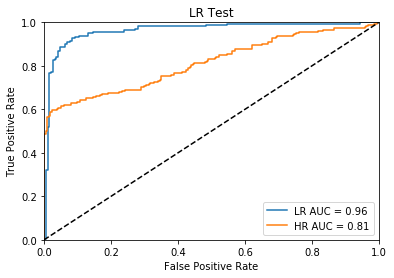

In [20]:
hparams={'continous':False,
         'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_lr_dataset.csv',
         'noncontinous_train_splits': ['train', 'base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='LR')

## Testing LR-base model

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': None,
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_lr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


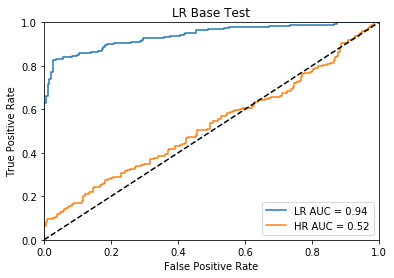

In [18]:
hparams={'continous':False,
         'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_lr_dataset.csv',
         'noncontinous_train_splits': ['base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='LR Base')

## Testing HR Model

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': None,
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_hr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['train', 'base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


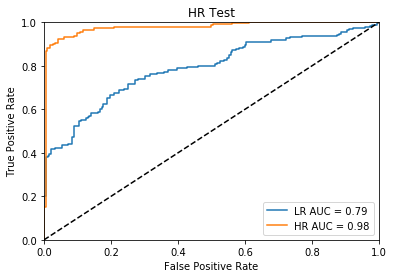

In [21]:
hparams={'continous':False,
         'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_hr_dataset.csv',
         'noncontinous_train_splits': ['train', 'base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='HR')

## Testing HR-base model

INFO:root:No continous learning, following parameters are invalidated: 
transition_phase_after 
cachemaximum 
use_cache 
random_cache 
force_misclassified 
direction


{'balance_cache': True,
 'base_model': None,
 'batch_size': 8,
 'cachemaximum': 128,
 'continous': False,
 'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_hr_dataset.csv',
 'direction': 'lr->hr',
 'force_misclassified': False,
 'noncontinous_steps': 3000,
 'noncontinous_train_splits': ['base_train'],
 'random_cache': True,
 'root_dir': '/project/catinous/cat_data/',
 'run_postfix': '1',
 'training_batch_size': 8,
 'transition_phase_after': 0.7,
 'use_cache': False,
 'val_check_interval': 100}


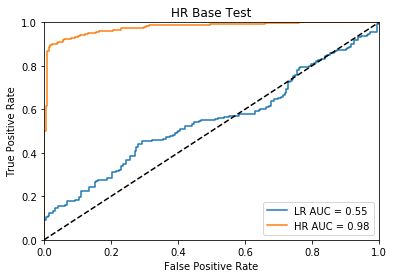

In [22]:
hparams={'continous':False,
         'datasetfile': '/home/cir/mperkonigg/catinous/catinous/catsinom_hr_dataset.csv',
         'noncontinous_train_splits': ['base_train'],
         'noncontinous_steps': 3000}
model, logs, df_cache = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

plot_test_roc(model, {'LR': test_lr, 'HR': test_hr}, device, mname='HR Base')

## Testing combined model

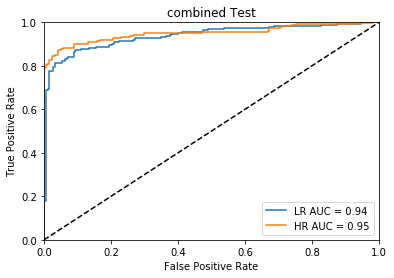

In [13]:
plot_test_roc('combined', {'LR': test_lr, 'HR': test_hr}, device)

## Testing LR-HR

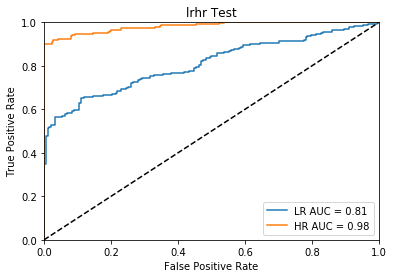

In [4]:
plot_test_roc('lrhr', {'LR': test_lr, 'HR': test_hr}, device)

## Testing HR-LR

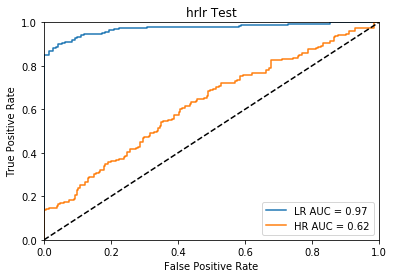

In [5]:
plot_test_roc('hrlr', {'LR': test_lr, 'HR': test_hr}, device)

# Continous training random cache

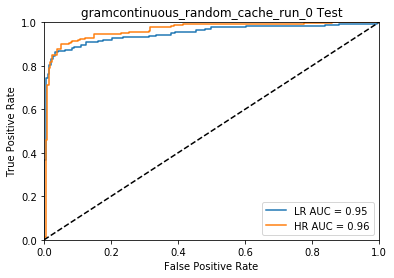

In [10]:
plot_test_roc_gram('gramcontinuous_random_cache_run_0', {'LR': test_lr, 'HR': test_hr}, device)

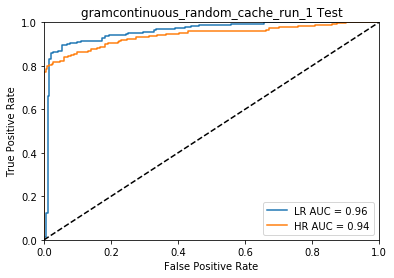

In [9]:
plot_test_roc_gram('gramcontinuous_random_cache_run_1', {'LR': test_lr, 'HR': test_hr}, device)

# continous without cache

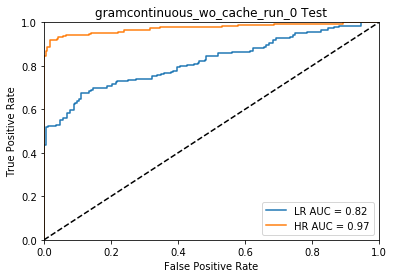

In [5]:
plot_test_roc_gram('gramcontinuous_wo_cache_run_0', {'LR': test_lr, 'HR': test_hr}, device)

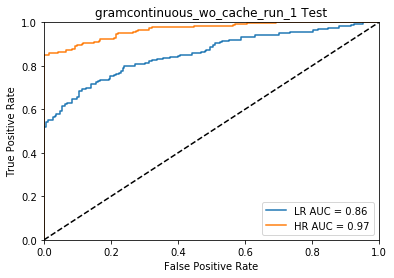

In [6]:
plot_test_roc_gram('gramcontinuous_wo_cache_run_1', {'LR': test_lr, 'HR': test_hr}, device)

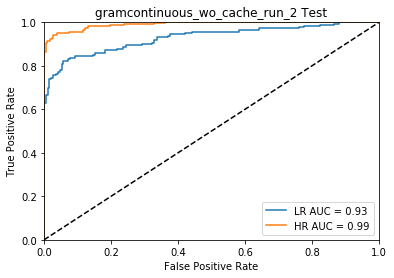

In [7]:
plot_test_roc_gram('gramcontinuous_wo_cache_run_2', {'LR': test_lr, 'HR': test_hr}, device)

# Result Figures

In [3]:
df_wo_cache = None
for i in range(3):
    df_temp = pd.read_csv('catinous_log_iterations/continuous_wo_cache/version_'+str(i)+'/metrics.csv')
    df_temp = df_temp.loc[df_temp['val_loss_lr']==df_temp['val_loss_lr']]
    df_temp['idx'] = range(len(df_temp))
    if df_wo_cache is None:
        df_wo_cache = df_temp
    else:
        df_wo_cache = df_wo_cache.append(df_temp)
        
        
df_randomcache = None

for i in range(3):
    df_temp = pd.read_csv('catinous_log_iterations/continuous_random_cache/version_'+str(i)+'/metrics.csv')
    df_temp = df_temp.loc[df_temp['val_loss_lr']==df_temp['val_loss_lr']]
    df_temp['idx'] = range(len(df_temp))
    if df_randomcache is None:
        df_randomcache = df_temp
    else:
        df_randomcache = df_randomcache.append(df_temp)


In [4]:
streamedDS = StreamedDS('/project/catinous/cat_data/','catsinom_combined_dataset.csv', transition_phase_after=0.7, direction='lr->hr')
res = streamedDS.df.res == 'lr'

In [5]:
newcmp = ListedColormap([sns.color_palette()[1], sns.color_palette()[0]], name='OrangeBlue')

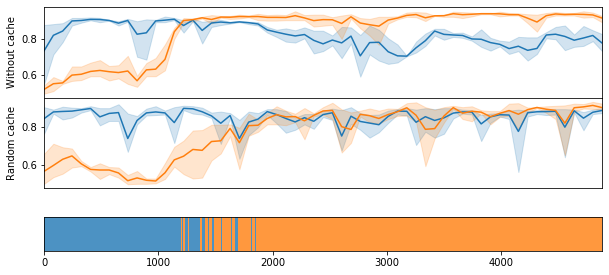

In [6]:
fig, ax = plt.subplots(3,1, figsize=(10, 5))

plt.subplots_adjust(hspace=0.0)

sns.lineplot(data=df_wo_cache, y='val_acc_lr', x='idx', ax=ax[0])
sns.lineplot(data=df_wo_cache, y='val_acc_hr', x='idx', ax=ax[0])
ax[0].get_xaxis().set_visible(False)
ax[0].set_xlim(0, 60)
ax[0].set_ylabel('Without cache')

sns.lineplot(data=df_randomcache, y='val_acc_lr', x='idx', ax=ax[1])
sns.lineplot(data=df_randomcache, y='val_acc_hr', x='idx', ax=ax[1])
ax[1].get_xaxis().set_visible(False)
ax[1].set_xlim(0, 60)
ax[1].set_ylabel('Random cache')

ax[2].imshow(np.tile(res,(300,1)), cmap=newcmp, alpha=0.8)
ax[2].get_yaxis().set_visible(False)
ax[2].get_yaxis()

# Analyze Cache

In [2]:
def plot_cache_imgs(df):
    imgs = []
    for fp in df.filepath:
        simg = sitk.ReadImage(os.path.join('/project/catinous/cat_data', fp))
        img = sitk.GetArrayFromImage(simg)

        img = mut.intensity_window(img, low=-1024, high=400)
        img = mut.norm01(img)
        imgs.append(img[0])

    mut.mimshow(np.asarray(imgs), nslic=len(df))

In [62]:
df_cache = pd.read_csv('/project/catinous/trained_cache/continous_random_cache_cachesize_128_run_0.csv')

In [63]:
df_cache.groupby('res').count()

filepath  label  traincounter
res                               
hr         56     56            56
lr         72     72            72

In [64]:
df_cache.groupby('label').count()

filepath  res  traincounter
label                             
0            31   31            31
1            97   97            97

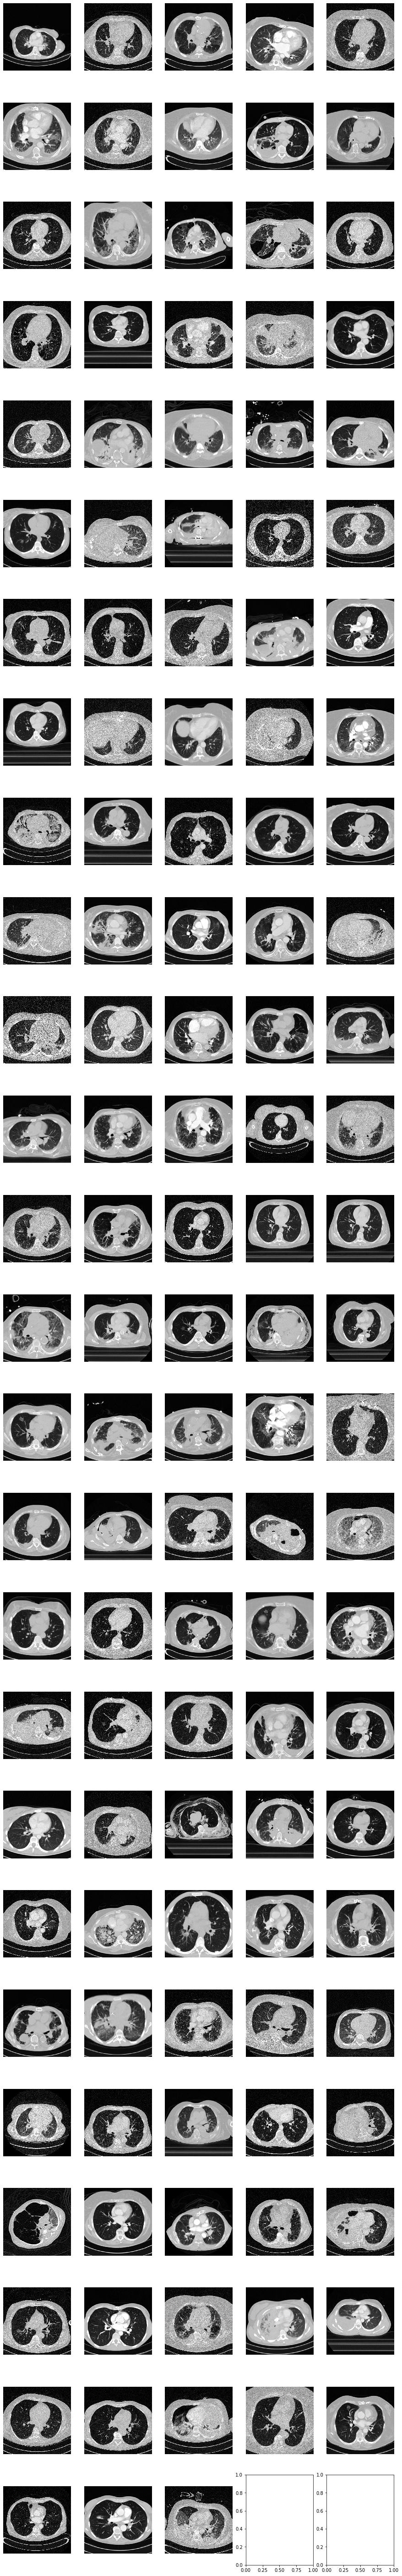

In [65]:
plot_cache_imgs(df_cache)